# **실습 문제**
* 10개의 이미지를 분류하는 문제
* 과적합 방지 기법 2가지 적용
* 랜덤 서치를 이용하여 하이퍼 파라미터 튜닝 수행
* 하이퍼 파라미터의 개수는 최소 3개 이상 적용

In [1]:
import os
import random
import shutil
from sklearn.model_selection import train_test_split
import imgaug.augmenters as iaa
from PIL import Image
import os
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from PIL import Image

2024-12-16 06:21:19.787010: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-16 06:21:19.813292: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-16 06:21:20.220085: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### **0. 데이터 준비**
* Cifar10 Dataset
* 10개의 클래스(비행기, 자동차, 새, 고양이, 사슴, 개, 개구리, 말, 배, 트럭)으로 구성된 32x32 픽셀의 컬러 이미지 데이터셋

### **1. 데이터셋 경로 설정**

In [18]:
# 1. 데이터셋 경로 설정
original_data_dir = "cifar10_images" 
output_base_dir = "cifar10_dataset"
train_dir = os.path.join(output_base_dir, "train")
valid_dir = os.path.join(output_base_dir, "valid")
test_dir = os.path.join(output_base_dir, "test")

### **2. 데이터셋 분할: 0.7 (Train), 0.2 (Validation), 0.1 (Test)**

In [19]:
def split_data(original_dir, train_ratio=0.7, valid_ratio=0.2):
    # 클래스별 데이터를 나눔
    class_dirs = [os.path.join(original_dir, class_name) for class_name in os.listdir(original_dir)]
    for class_dir in class_dirs:
        if not os.path.isdir(class_dir):
            continue

        # 각 클래스의 이미지 경로
        images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith(('.png', '.jpg'))]
        random.shuffle(images)

        # 분할
        train_split = int(len(images) * train_ratio)
        valid_split = int(len(images) * (train_ratio + valid_ratio))

        train_images = images[:train_split]
        valid_images = images[train_split:valid_split]
        test_images = images[valid_split:]

        # 데이터를 출력 디렉토리에 저장
        for output_dir, image_set in zip([train_dir, valid_dir, test_dir], [train_images, valid_images, test_images]):
            class_output_dir = os.path.join(output_dir, os.path.basename(class_dir))
            os.makedirs(class_output_dir, exist_ok=True)
            for image_path in image_set:
                shutil.copy(image_path, class_output_dir)

split_data(original_data_dir)

### **3. Data 전처리**

In [23]:
import os
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
# 데이터 로드 함수 수정
def load_data(data_dir, image_size=(32, 32)):
    images = []
    labels = []
    
    # 디렉토리 구조 탐색
    for class_name in sorted(os.listdir(data_dir)):  # 클래스는 디렉토리 이름
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):  # 디렉토리가 아니면 건너뜀
            continue
        
        # 각 클래스의 이미지 탐색
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            if img_path.endswith(('.png', '.jpg', '.jpeg')):  # 이미지 파일만 처리
                # 이미지 로드 및 전처리
                img = Image.open(img_path).convert('RGB')  # RGB 변환
                img = img.resize(image_size)  # 크기 조정
                img = np.array(img) / 255.0  # 정규화 (0~1)
                images.append(img)  # (32, 32, 3) 유지
                labels.append(class_name)  # 라벨 추가
    
    # NumPy 배열로 변환
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels)
    
    # 라벨을 원-핫 인코딩
    lb = LabelEncoder()
    labels = lb.fit_transform(labels)
    
    return images, labels


In [24]:
# 데이터 로드
X_train, y_train = load_data(train_dir)
X_valid, y_valid = load_data(valid_dir)
X_test, y_test = load_data(test_dir)

In [25]:
print(X_train.shape)

(4569, 32, 32, 3)


In [26]:
# CNN 모델 정의 함수 수정
def build_cnn_model(input_shape=(32, 32, 3), num_classes=10):
    model = Sequential()

    # 첫 번째 Convolutional Layer
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 두 번째 Convolutional Layer
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten Layer
    model.add(Flatten())

    # Fully Connected Layer
    model.add(Dense(units=128, activation='relu'))

    # Output Layer
    model.add(Dense(units=num_classes, activation='softmax'))

    # 모델 컴파일
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    return model



In [15]:
# CNN 모델 학습 및 평가 함수 수정
def train_and_evaluate_cnn_model(X_train, y_train, X_valid, y_valid, X_test, y_test, model, epochs, description):
    print(f"\nTraining with {description} data...\n")

    # 모델 학습
    history = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        epochs=epochs,
        batch_size=32,  # CIFAR-10에 맞게 배치 크기 조정
        verbose=1
    )

    # Test 데이터 성능 평가
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nTest Accuracy ({description}): {test_accuracy * 100:.2f}%\n")
    return history

In [16]:
import matplotlib.pyplot as plt

def plot_training_history(history, description):
    # 학습 및 검증 손실 곡선
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{description} - Loss')
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 학습 및 검증 정확도 곡선
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{description} - Accuracy')
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


Training with CIFAR-10 CNN Model data...

Epoch 1/10


2024-12-16 06:22:17.228503: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-16 06:22:17.244914: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-16 06:22:17.245059: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

110/110 [==============================] - 2s 6ms/step - loss: 2.0904 - accuracy: 0.2154 - val_loss: 1.7950 - val_accuracy: 0.3768
Epoch 2/10
110/110 [==============================] - 0s 4ms/step - loss: 1.6902 - accuracy: 0.3877 - val_loss: 1.6389 - val_accuracy: 0.4081
Epoch 3/10
110/110 [==============================] - 0s 4ms/step - loss: 1.5120 - accuracy: 0.4566 - val_loss: 1.6169 - val_accuracy: 0.4212
Epoch 4/10
110/110 [==============================] - 0s 3ms/step - loss: 1.3861 - accuracy: 0.5129 - val_loss: 1.4770 - val_accuracy: 0.4687
Epoch 5/10
110/110 [==============================] - 0s 4ms/step - loss: 1.2509 - accuracy: 0.5551 - val_loss: 1.4509 - val_accuracy: 0.4899
Epoch 6/10
110/110 [==============================] - 0s 3ms/step - loss: 1.1539 - accuracy: 0.6017 - val_loss: 1.4729 - val_accuracy: 0.4909
Epoch 7/10
110/110 [==============================] - 1s 5ms/step - loss: 1.0466 - accuracy: 0.6249 - val_loss: 1.5463 - val_accuracy: 0.4798
Epoch 8/10
110/11

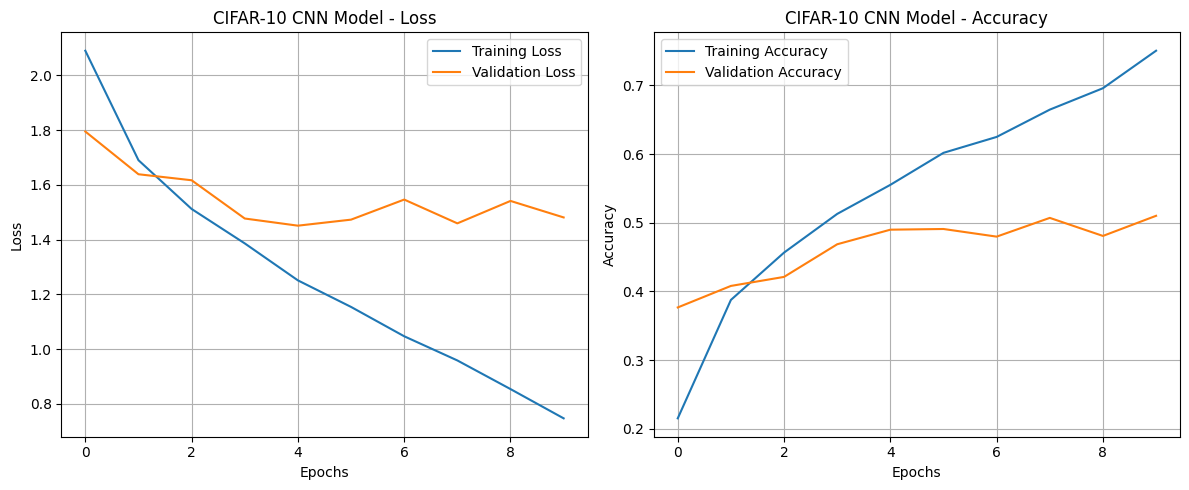

In [17]:
# 데이터 로드
X_train, y_train = load_data(train_dir)
X_valid, y_valid = load_data(valid_dir)
X_test, y_test = load_data(test_dir)

# 모델 생성
model = build_cnn_model()

# 학습 및 평가
history = train_and_evaluate_cnn_model(X_train, y_train, X_valid, y_valid, X_test, y_test, model, epochs=10, description="CIFAR-10 CNN Model")

# 학습 곡선 시각화
plot_training_history(history, "CIFAR-10 CNN Model")

## **문제 1. 과적합 방지를 위한 기법을 2가지 이상 적용하고 학습해보세요**

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [30]:
def build_cnn_model(input_shape=(32, 32, 3), num_classes=10):
    model = Sequential()

    # 첫 번째 Convolutional Layer
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # 두 번째 Convolutional Layer
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.2))
              
    # Flatten Layer
    model.add(Flatten())

    # Fully Connected Layer with Dropout
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(rate=0.5))  # Dropout Layer 추가

    # Output Layer
    model.add(Dense(units=num_classes, activation='softmax'))

    # 모델 컴파일
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    return model

In [31]:
# CNN 모델 학습 및 평가 함수 수정
def train_and_evaluate_cnn_model(X_train, y_train, X_valid, y_valid, X_test, y_test, model, epochs, description):
    print(f"\nTraining with {description} data...\n")

    # Early Stopping Callback 설정
    early_stop = EarlyStopping(
        monitor='val_loss',       # 검증 손실(val_loss)을 모니터링
        patience=5,               # 성능 개선이 없으면 5회(epoch) 후 중지
        restore_best_weights=True # 가장 성능이 좋았던 가중치를 복원
    )

    # 모델 학습
    history = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        epochs=epochs,
        batch_size=32,  # CIFAR-10에 맞게 배치 크기 조정
        verbose=1,
        callbacks=[early_stop]  # Early Stopping 추가
    )

    # Test 데이터 성능 평가
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nTest Accuracy ({description}): {test_accuracy * 100:.2f}%\n")
    return history


Training with Solve Overfitting data...

Epoch 1/50


2024-12-16 06:37:24.542359: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


143/143 [==============================] - 2s 6ms/step - loss: 2.1487 - accuracy: 0.2027 - val_loss: 1.9300 - val_accuracy: 0.2919
Epoch 2/50
143/143 [==============================] - 1s 6ms/step - loss: 1.8770 - accuracy: 0.3145 - val_loss: 1.6872 - val_accuracy: 0.3932
Epoch 3/50
143/143 [==============================] - 1s 4ms/step - loss: 1.7181 - accuracy: 0.3771 - val_loss: 1.5631 - val_accuracy: 0.4474
Epoch 4/50
143/143 [==============================] - 1s 7ms/step - loss: 1.6050 - accuracy: 0.4213 - val_loss: 1.4542 - val_accuracy: 0.4810
Epoch 5/50
143/143 [==============================] - 1s 6ms/step - loss: 1.5459 - accuracy: 0.4340 - val_loss: 1.3818 - val_accuracy: 0.5073
Epoch 6/50
143/143 [==============================] - 1s 5ms/step - loss: 1.4635 - accuracy: 0.4695 - val_loss: 1.3182 - val_accuracy: 0.5274
Epoch 7/50
143/143 [==============================] - 1s 5ms/step - loss: 1.4102 - accuracy: 0.4944 - val_loss: 1.3280 - val_accuracy: 0.5134
Epoch 8/50
143/14

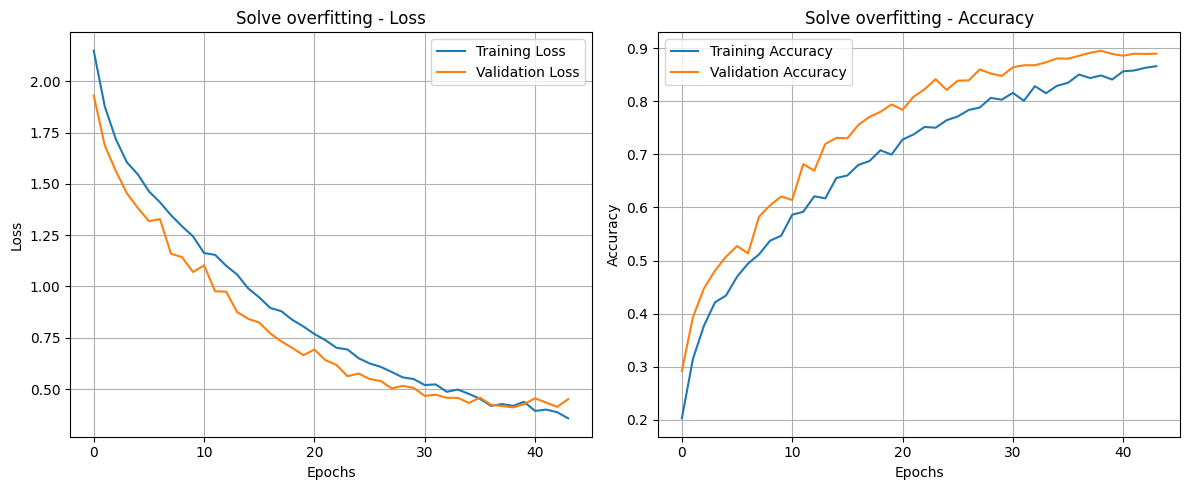

In [32]:
# 데이터 로드
X_train, y_train = load_data(train_dir)
X_valid, y_valid = load_data(valid_dir)
X_test, y_test = load_data(test_dir)

# 모델 생성
model = build_cnn_model()

# 학습 및 평가
history = train_and_evaluate_cnn_model(X_train, y_train, X_valid, y_valid, X_test, y_test, model, epochs=50, description="Solve Overfitting")
# 학습 곡선 시각화
plot_training_history(history, "Solve overfitting")

## **문제 2.  BayesianOptimization을 수행하여 SGD,  SGD with Momentum,   AdaGrad, RMSProp, Adam에 대한 하이퍼 파라미터 튜닝을 수행하세요**

In [38]:
from kerastuner.tuners import BayesianOptimization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad

# Keras Tuner에서 사용할 모델 생성 함수
def build_model(hp):
    model = Sequential()

    # 첫 번째 Convolutional Layer
    model.add(Conv2D(
        filters=hp.Choice('filters1', values=[32, 64]),  # 필터 수 최적화
        kernel_size=(3, 3), 
        activation='relu', 
        input_shape=(32, 32, 3)
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 두 번째 Convolutional Layer
    model.add(Conv2D(
        filters=hp.Choice('filters2', values=[64, 128]),  # 필터 수 최적화
        kernel_size=(3, 3), 
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=hp.Choice('dropout_conv', values=[0.2, 0.3, 0.4])))  # Dropout 최적화

    # Flatten Layer
    model.add(Flatten())

    # Fully Connected Layer with Dropout
    model.add(Dense(
        units=hp.Choice('dense_units', values=[64, 128, 256]),  # Dense Layer 뉴런 수 최적화
        activation='relu'
    ))
    model.add(Dropout(rate=hp.Choice('dropout_dense', values=[0.3, 0.4, 0.5])))  # Dropout 최적화

    # Output Layer
    model.add(Dense(units=10, activation='softmax'))

    # Optimizer 설정
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop', 'adagrad', 'sgd_momentum'])

    # Optimizer 파라미터 설정
    learning_rate = hp.Choice('learning_rate', values=[0.001, 0.0001])
    if optimizer_choice == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer_choice == 'adagrad':
        opt = Adagrad(learning_rate=learning_rate)
    elif optimizer_choice == 'sgd_momentum':
        momentum = hp.Choice('momentum', values=[0.8, 0.9])  # Momentum 추가
        opt = SGD(learning_rate=learning_rate, momentum=momentum)

    # 모델 컴파일
    model.compile(
        optimizer=opt,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Keras Tuner Bayesian Optimization 설정
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',  # 검증 정확도를 최적화
    max_trials=10,            # 시도할 하이퍼파라미터 조합 수
    executions_per_trial=1,   # 각 조합에 대해 몇 번 실행할지
    directory='bayesian_opt', # 결과 저장 디렉토리
    project_name='cnn_tuning' # 프로젝트 이름
)

# 데이터 준비
X_train_reshaped = X_train.reshape(-1, 32, 32, 3)  # 4D 텐서로 변환
X_valid_reshaped = X_valid.reshape(-1, 32, 32, 3)
X_test_reshaped = X_test.reshape(-1, 32, 32, 3)

# Bayesian Optimization 실행
tuner.search(
    X_train_reshaped, y_train, 
    validation_data=(X_valid_reshaped, y_valid),
    epochs=10, 
    batch_size=32
)

# 최적 하이퍼파라미터 출력
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

# 최적 모델로 학습 및 평가
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train_reshaped, y_train,
    validation_data=(X_valid_reshaped, y_valid),
    epochs=10,
    batch_size=32
)

# 테스트 데이터 평가
test_loss, test_accuracy = best_model.evaluate(X_test_reshaped, y_test, verbose=0)
print(f"Test Accuracy with Best Model: {test_accuracy * 100:.2f}%")

INFO:tensorflow:Reloading Tuner from bayesian_opt/cnn_tuning/tuner0.json
INFO:tensorflow:Oracle triggered exit
Best hyperparameters: {'filters1': 64, 'filters2': 64, 'dropout_conv': 0.2, 'dense_units': 64, 'dropout_dense': 0.3, 'learning_rate': 0.001}
Epoch 1/10


2024-12-16 06:49:24.619989: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


143/143 [==============================] - 1s 4ms/step - loss: 2.1621 - accuracy: 0.1828 - val_loss: 1.9468 - val_accuracy: 0.3087
Epoch 2/10
143/143 [==============================] - 1s 4ms/step - loss: 1.9149 - accuracy: 0.2937 - val_loss: 1.7106 - val_accuracy: 0.3999
Epoch 3/10
143/143 [==============================] - 1s 4ms/step - loss: 1.7321 - accuracy: 0.3684 - val_loss: 1.6134 - val_accuracy: 0.4329
Epoch 4/10
143/143 [==============================] - 0s 3ms/step - loss: 1.6241 - accuracy: 0.4069 - val_loss: 1.6380 - val_accuracy: 0.4189
Epoch 5/10
143/143 [==============================] - 0s 2ms/step - loss: 1.5523 - accuracy: 0.4358 - val_loss: 1.3926 - val_accuracy: 0.5006
Epoch 6/10
143/143 [==============================] - 0s 2ms/step - loss: 1.5041 - accuracy: 0.4502 - val_loss: 1.3387 - val_accuracy: 0.5185
Epoch 7/10
143/143 [==============================] - 1s 5ms/step - loss: 1.4504 - accuracy: 0.4695 - val_loss: 1.3041 - val_accuracy: 0.5414
Epoch 8/10
143/14

1/1 [==============================] - 0s 11ms/step


error: OpenCV(4.10.0) /io/opencv/modules/core/src/arithm.cpp:658: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'


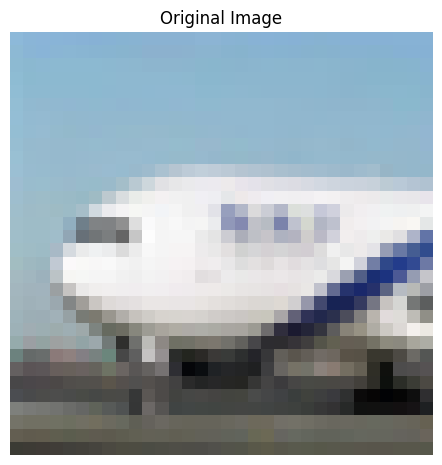

In [75]:
def grad_cam(model, img, layer_name, class_idx):
    """
    Grad-CAM 생성 함수
    model: 학습된 Keras 모델
    img: 입력 이미지 (shape: (1, height, width, channels))
    layer_name: Grad-CAM을 적용할 Convolutional Layer 이름
    class_idx: 관심 있는 클래스 인덱스
    """
    # Grad-CAM을 적용할 레이어
    layer = model.get_layer(layer_name)
    
    # Grad-CAM 모델 정의
    grad_model = Model(inputs=model.input, outputs=[layer.output, model.output])
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img)
        loss = predictions[:, class_idx]
    
    # 그레이디언트를 계산
    grads = tape.gradient(loss, conv_outputs)
    
    # 채널별 평균값 계산
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    # Convolutional Layer의 출력 가져오기
    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()
    
    # 채널별 가중치를 곱하고 합산
    for i in range(len(pooled_grads)):
        conv_outputs[:, :, i] *= pooled_grads[i]
    heatmap = np.mean(conv_outputs, axis=-1)
    
    # 열지도 정규화
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap
'''
# Grad-CAM 열지도 시각화 함수
def overlay_heatmap(heatmap, img, alpha=0.4):
    """
    원본 이미지 위에 열지도를 덧씌움
    heatmap: Grad-CAM으로 생성된 열지도
    img: 원본 이미지 (shape: (height, width, channels))
    alpha: 열지도의 투명도
    """
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlay_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    return overlay_img
'''
def overlay_heatmap(heatmap, img, alpha=0.4):
    """
    원본 이미지 위에 열지도를 덧씌움
    heatmap: Grad-CAM으로 생성된 열지도
    img: 원본 이미지 (shape: (height, width, 3))
    alpha: 열지도의 투명도
    """
    # 열지도를 [0, 255] 범위의 uint8로 변환
    heatmap = np.uint8(255 * heatmap)
    
    # 열지도를 컬러맵 형태로 변환 (RGB)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # 원본 이미지를 [0, 255] 범위로 변환
    img = (img * 255).astype(np.uint8)
    
    # 열지도와 원본 이미지 크기 확인 및 덧씌움
    overlay_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    return overlay_img

# Grad-CAM 적용
sample_img = X_test[0]  # 테스트 이미지 선택
sample_img_input = np.expand_dims(sample_img, axis=0)  # 배치 차원 추가

# Grad-CAM 적용할 Convolutional Layer 지정
layer_name = 'conv2d_15'  # 모델 구조에 따라 레이어 이름 지정

# 예측 클래스 확인
predicted_class = np.argmax(model.predict(sample_img_input))  # 예측 클래스

# Grad-CAM 계산
heatmap = grad_cam(model, sample_img_input, layer_name=layer_name, class_idx=predicted_class)

# Grad-CAM 시각화
plt.figure(figsize=(12, 6))

# 원본 이미지
plt.subplot(1, 2, 1)
plt.imshow(sample_img)
plt.title("Original Image")
plt.axis("off")

# Grad-CAM Overlay
overlay_img = overlay_heatmap(heatmap, (sample_img * 255).astype(np.uint8))
plt.subplot(1, 2, 2)
plt.imshow(overlay_img)
plt.title("Grad-CAM")
plt.axis("off")

plt.tight_layout()
plt.show()

In [69]:
# 모델의 레이어 이름 확인
for layer in model.layers:
    print(layer.name)

conv2d_14
max_pooling2d_14
conv2d_15
max_pooling2d_15
flatten_7
dense_14
dense_15


In [70]:
layer_name='conv2d_15'

In [72]:
X_test[0].shape

(32, 32, 3)

In [71]:
# Grad-CAM 적용
sample_img = X_test[0]  # 테스트 이미지 선택
sample_img_input = np.expand_dims(sample_img, axis=0)  # 배치 차원 추가

predicted_class = np.argmax(model.predict(sample_img_input))  # 예측 클래스
heatmap = grad_cam(model, sample_img_input, layer_name=layer_name, class_idx=predicted_class)


1/1 [==============================] - 0s 13ms/step


TypeError: object of type 'numpy.float32' has no len()

In [67]:

# Grad-CAM 시각화
plt.figure(figsize=(12, 6))


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [ ]:
# 원본 이미지
plt.subplot(1, 2, 1)
plt.imshow(sample_img)
plt.title("Original Image")
plt.axis("off")

In [ ]:
# Grad-CAM Overlay
overlay_img = overlay_heatmap(heatmap, (sample_img * 255).astype(np.uint8))
plt.subplot(1, 2, 2)
plt.imshow(overlay_img)
plt.title("Grad-CAM")
plt.axis("off")

In [ ]:
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 11ms/step


error: OpenCV(4.10.0) /io/opencv/modules/core/src/arithm.cpp:658: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'


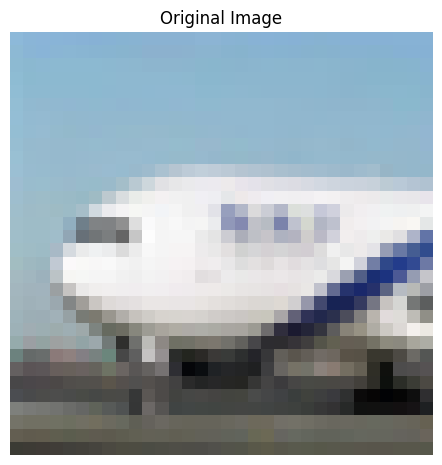

In [77]:
# Grad-CAM 적용
sample_img = X_test[0]  # 테스트 이미지 선택
sample_img_input = np.expand_dims(sample_img, axis=0)  # 배치 차원 추가

# Grad-CAM 적용할 Convolutional Layer 지정
layer_name = 'conv2d_15'  # 모델 구조에 따라 레이어 이름 지정

# 예측 클래스 확인
predicted_class = np.argmax(model.predict(sample_img_input))  # 예측 클래스

# Grad-CAM 계산
heatmap = grad_cam(model, sample_img_input, layer_name=layer_name, class_idx=predicted_class)

# Grad-CAM 시각화
plt.figure(figsize=(12, 6))

# 원본 이미지
plt.subplot(1, 2, 1)
plt.imshow(sample_img)
plt.title("Original Image")
plt.axis("off")

# Grad-CAM Overlay
overlay_img = overlay_heatmap(heatmap, sample_img)
plt.subplot(1, 2, 2)
plt.imshow(overlay_img)
plt.title("Grad-CAM")
plt.axis("off")

plt.tight_layout()
plt.show()